In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import math
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from mamba import *

In [2]:
stock_name = 'PEP'
df = yf.download(stock_name,
                 start='2016-06-01',
                 end='2019-01-26',
                 progress=False)
file_name = f'{stock_name}.csv'
df.to_csv(file_name)

In [3]:
df = pd.read_csv(file_name)
close_prices = df['Close']

In [4]:
print(close_prices.shape)

(668,)


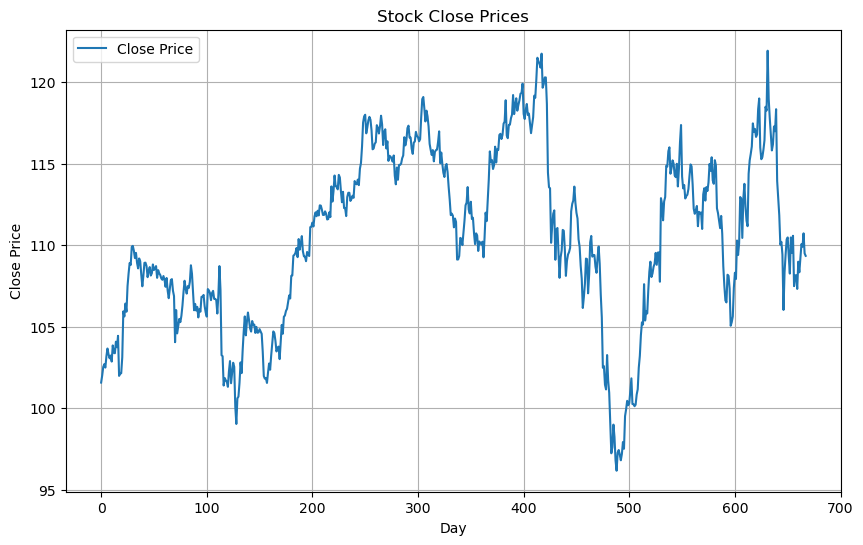

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(close_prices, label='Close Price')
plt.title('Stock Close Prices')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
pct_changes = close_prices.pct_change().dropna()*100

In [7]:
pct_changes = pct_changes.values.reshape(-1, 1)

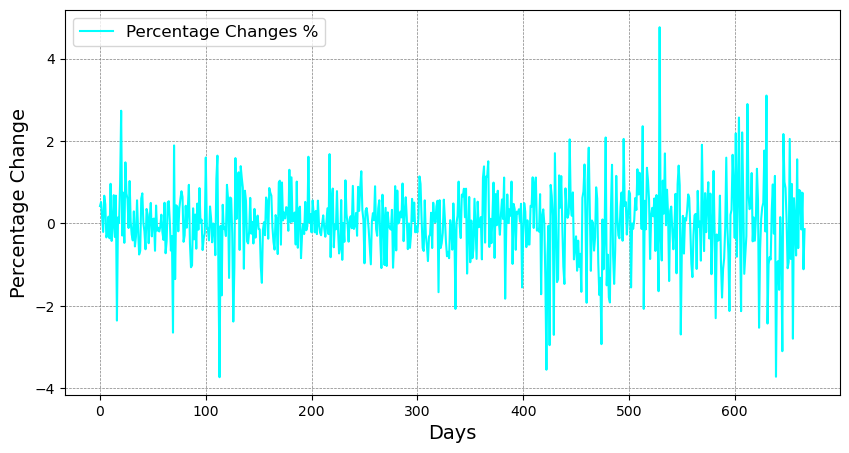

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(pct_changes, color='cyan', label='Percentage Changes %')
plt.title('', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Days', fontsize=14, color='black')
plt.ylabel('Percentage Change', fontsize=14, color='black')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray') 
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pct_changes = scaler.fit_transform(pct_changes)

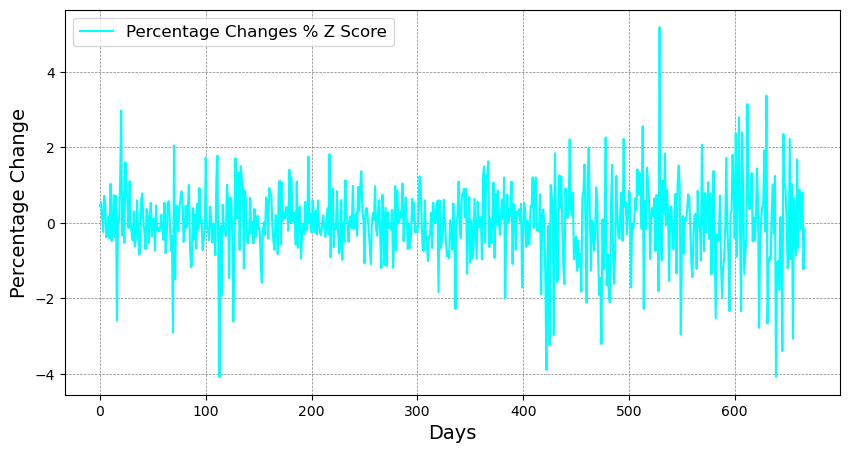

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(pct_changes, color='cyan', label='Percentage Changes % Z Score')
plt.title('', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Days', fontsize=14, color='black')
plt.ylabel('Percentage Change', fontsize=14, color='black')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray') 
plt.show()

In [11]:
print(pct_changes.shape)

(667, 1)


In [12]:
def create_time_series_windows(dataset, time_step=1):
    features, labels = [], []
    for i in range(len(dataset)-time_step):
        historical_data = dataset[i:(i+time_step), 0]
        features.append(historical_data)
        labels.append(dataset[i + time_step, 0])
    return np.array(features), np.array(labels)

In [13]:
time_step = 20
X, y = create_time_series_windows(pct_changes, time_step)

In [14]:
print(X.shape)

(647, 20)


In [15]:
test_size = 120
training_size = int(len(X) - test_size)
X_train, X_test = X[0:training_size], X[training_size:len(X)]
y_train, y_test = y[0:training_size], y[training_size:len(y)]

In [16]:
print("X_train")
print(X_train.shape)
print("\n")
print("y_train")
print(y_train.shape)
print("\n")
print("X_test")
print(X_test.shape)
print("\n")
print("y_test")
print(y_test.shape)

X_train
(527, 20)


y_train
(527,)


X_test
(120, 20)


y_test
(120,)


In [17]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [18]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [19]:
# Mamba configuration
"""
1. `d_model=64`:
   - `d_model` stands for the dimension of the model or the number of channels/features in the model.
   - A value of 64 suggests a moderate-sized model. It's not too small to lose expressive power, but not too large to make training and inference slow or memory-intensive.

2. `n_layers=3`:
   - `n_layers` specifies the number of transformer layers in the model.
   - With 3 layers, the model is kept relatively shallow, which can be beneficial for faster training and inference while still capturing some hierarchical features.

3. `dt_rank='auto'`:
   - `dt_rank` stands for the tensor train rank of the state tensor.
   - Choosing `'auto'` means that the rank is determined automatically based on the other parameters and the problem complexity. This can help in efficiently approximating the high-dimensional tensors in a compressed form.

4. `d_state=16`:
   - `d_state` is the dimensionality of the state tensor.
   - A smaller state dimension reduces the number of parameters and memory usage, making the model more efficient.

5. `expand_factor=2`:
   - `expand_factor` is used to determine the number of output channels in the convolutional layers.
   - An `expand_factor` of 2 means that the number of channels will double in the convolutional layers. This can increase the model's capacity without significantly increasing its size.

6. `d_conv=4`:
   - `d_conv` specifies the number of channels in the convolutional layers.
   - With a small value like 4, the convolutional layers are relatively lightweight, focusing on extracting low-level features.

7. `dt_min=0.001` and `dt_max=0.1`:
   - `dt_min` and `dt_max` define the minimum and maximum values for the time step in the simulation.
   - The chosen range allows for flexibility in adapting to different dynamics in the data.

8. `dt_init="random"`:
   - `dt_init` specifies how the time step is initialized.
   - Random initialization can help in exploring the solution space effectively during training.

9. `dt_scale=1.0`:
   - `dt_scale` scales the time step during training.
   - A scale of 1.0 means no scaling, providing a balanced trade-off between accuracy and stability.

10. `bias=False` and `conv_bias=True`:
   - `bias` determines whether to include bias terms in linear layers.
   - `conv_bias` determines whether to include bias terms in convolutional layers.
   - Excluding biases in linear layers can help reduce the number of parameters, while including biases in convolutional layers can improve the model's capacity to learn from the data.

11. `pscan=True`:
   - `pscan` enables or disables parallel scanning.
   - Parallel scanning can improve the efficiency of the simulation by processing multiple data points simultaneously.

Overall, the chosen configuration aims to strike a balance between model complexity and efficiency, ensuring that the model is capable of capturing relevant features in the data while being practical to train and deploy.
"""
config = MambaConfig(
    d_model=128,
    n_layers=3,
    dt_rank='auto',
    d_state=16,
    expand_factor=2,
    d_conv=4,
    dt_min=0.001,
    dt_max=0.1,
    dt_init="random",
    dt_scale=1.0,
    bias=False,
    conv_bias=True,
    pscan=True
)

model = Mamba(config)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print(model)

Mamba(
  (layers): ModuleList(
    (0-2): 3 x ResidualBlock(
      (mixer): MambaBlock(
        (in_proj): Linear(in_features=128, out_features=512, bias=False)
        (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
        (x_proj): Linear(in_features=256, out_features=40, bias=False)
        (dt_proj): Linear(in_features=8, out_features=256, bias=True)
        (out_proj): Linear(in_features=256, out_features=128, bias=False)
      )
      (norm): RMSNorm()
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
)


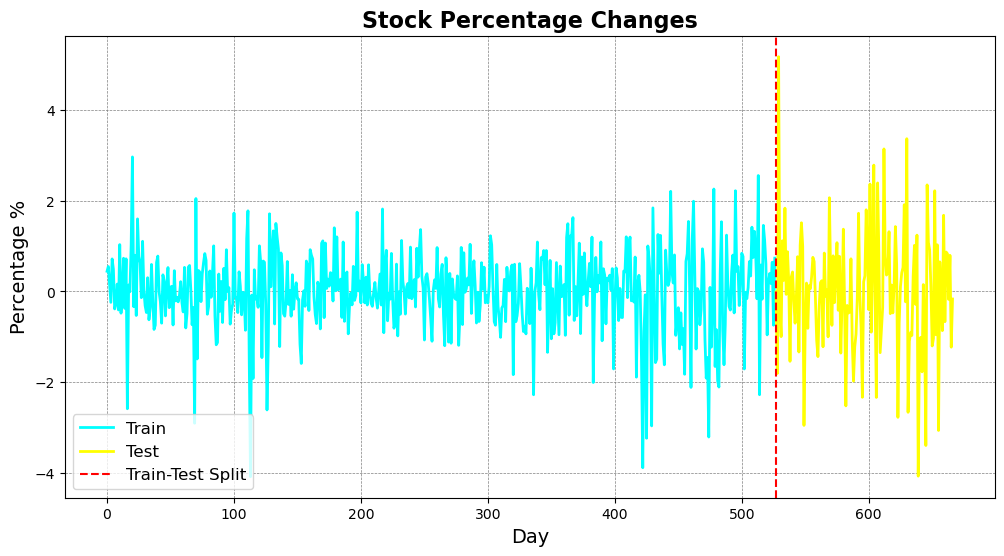

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, training_size), pct_changes[0:training_size], color='cyan', label='Train', linewidth=2)
plt.plot(np.arange(training_size, len(pct_changes)), pct_changes[training_size:len(pct_changes)], color='yellow', label='Test', linewidth=2)
plt.axvline(x=training_size, color='red', linestyle='--', label='Train-Test Split')
plt.title('Stock Percentage Changes', fontsize=16, fontweight='bold')
plt.xlabel('Day', fontsize=14)
plt.ylabel('Percentage %', fontsize=14)
plt.legend(loc='lower left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

In [21]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

val_dataset = TensorDataset(X_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_epochs = 30
train_losses = []
val_losses = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


for epoch in range(num_epochs):
    model.train() #Allows the model to switch to training mode.
    total_loss = 0
    total_squared_error = 0  

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)

        # Select the last prediction from each sequence in outputs
        last_outputs = outputs[:, -1, -1]

        # Compute the loss
        loss = criterion(last_outputs, batch_y)

        # Compute squared error
        squared_error = torch.square(last_outputs - batch_y).sum().item()
        total_squared_error += squared_error

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    avg_squared_error = total_squared_error / len(train_loader.dataset)
    rmse = math.sqrt(avg_squared_error)  # Calculate RMSE

    # Save the training loss for this epoch
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            last_outputs = outputs[:, -1, -1]
            val_loss = criterion(last_outputs, batch_y)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

print("Training completed!")

Epoch [1/30], Train Loss: 1.811549, Val Loss: 3.013768
Epoch [2/30], Train Loss: 1.402732, Val Loss: 2.628584
Epoch [3/30], Train Loss: 1.423381, Val Loss: 2.478267
Epoch [4/30], Train Loss: 1.366424, Val Loss: 2.398908
Epoch [5/30], Train Loss: 1.351107, Val Loss: 2.356472
Epoch [6/30], Train Loss: 1.211385, Val Loss: 2.329766
Epoch [7/30], Train Loss: 1.201825, Val Loss: 2.307844
Epoch [8/30], Train Loss: 1.163486, Val Loss: 2.273438
Epoch [9/30], Train Loss: 1.186256, Val Loss: 2.231863
Epoch [10/30], Train Loss: 1.130282, Val Loss: 2.182643
Epoch [11/30], Train Loss: 1.056737, Val Loss: 2.139282
Epoch [12/30], Train Loss: 1.032508, Val Loss: 2.085055
Epoch [13/30], Train Loss: 1.026699, Val Loss: 2.054347
Epoch [14/30], Train Loss: 1.016952, Val Loss: 2.053084
Epoch [15/30], Train Loss: 1.015433, Val Loss: 2.022671
Epoch [16/30], Train Loss: 1.012919, Val Loss: 2.016930
Epoch [17/30], Train Loss: 1.031790, Val Loss: 1.992291
Epoch [18/30], Train Loss: 1.010418, Val Loss: 1.966539
E

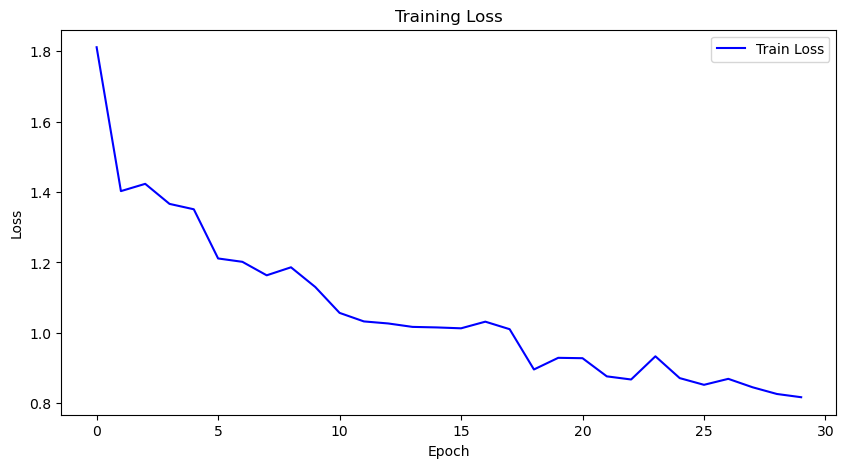

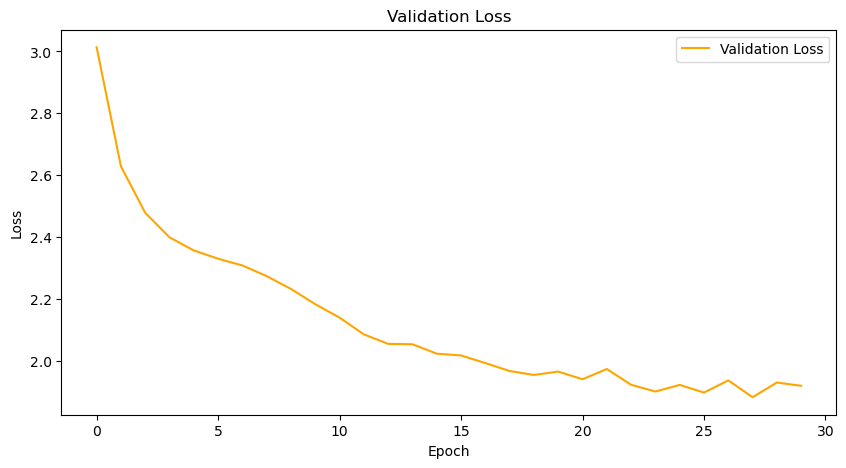

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('pep_train_loss.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.savefig('pep_val_loss.png') 
plt.show()

In [23]:
X_train_tensor = X_train.clone().detach().to(device).view(-1, time_step, 1)
X_test_tensor = X_test.clone().detach().to(device).view(-1, time_step, 1)

with torch.no_grad():
    y_train_pred = model(X_train_tensor)[:, -1, -1]
    y_test_pred = model(X_test_tensor)[:, -1, -1]

y_train_pred = y_train_pred.cpu().numpy()  
y_test_pred = y_test_pred.cpu().numpy()   


In [24]:
y_train_pred = y_train_pred.reshape(-1, 1)
y_test_pred = y_test_pred.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

In [25]:
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)
pct_changes = scaler.inverse_transform(pct_changes)

In [26]:
rmse_train = math.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = math.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'Train RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')

Train RMSE: 0.7833
Test RMSE: 1.2605


In [27]:
print(y_test_pred.shape)

(120, 1)


(667, 1)


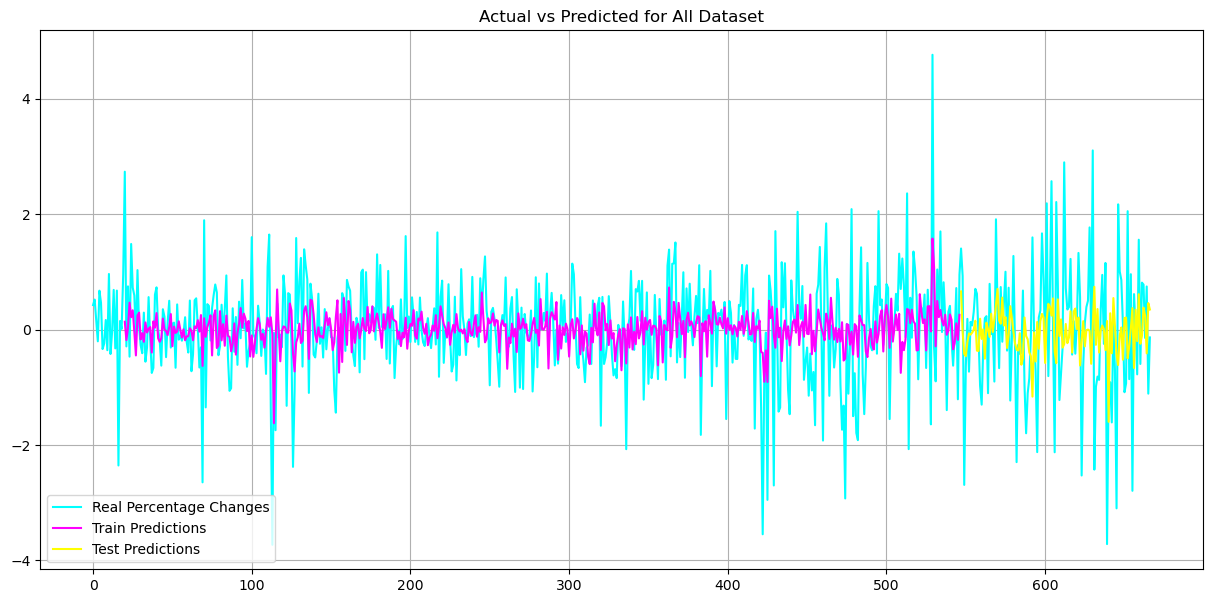

In [28]:
window_size = time_step
train_out = np.empty_like(pct_changes)
train_out[:, :] = np.nan
print(train_out.shape)
train_out[window_size:window_size+len(y_train_pred), :] = y_train_pred

test_out = np.empty_like(pct_changes)
test_out[:, :] = np.nan
test_out[window_size+len(y_train_pred):window_size+len(y_train_pred)+len(y_test_pred), :] = y_test_pred

plt.figure(figsize=(15, 7))
plt.plot(pct_changes.reshape(-1, 1), label='Real Percentage Changes', color='cyan')
plt.plot(train_out, label='Train Predictions', color='magenta')
plt.plot(test_out, label='Test Predictions', color='yellow')
plt.title('Actual vs Predicted for All Dataset')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

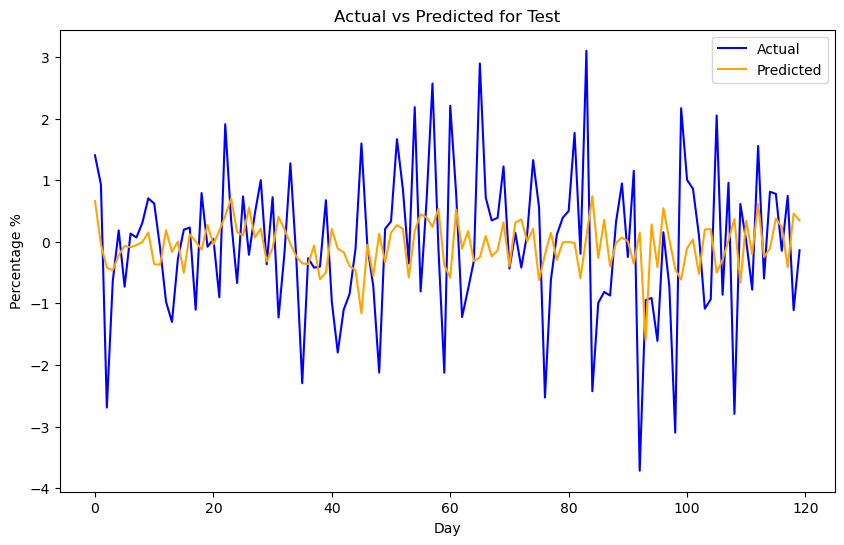

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_test_pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted for Test')
plt.xlabel('Day')
plt.ylabel('Percentage %')
plt.legend()
plt.savefig('pep_actual_predicted.png')
plt.show()

In [30]:
y_test_binary = np.where(y_test > 0, 1, 0)
y_pred_binary = np.where(y_test_pred > 0, 1, 0)

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.50
Precision: 0.50
Recall: 0.47
Balanced Accuracy: 0.50
F1 Score: 0.48


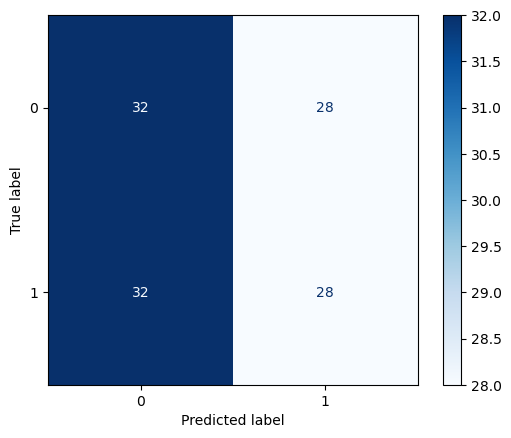

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_binary, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('pep_conf_mat.png')
plt.show()

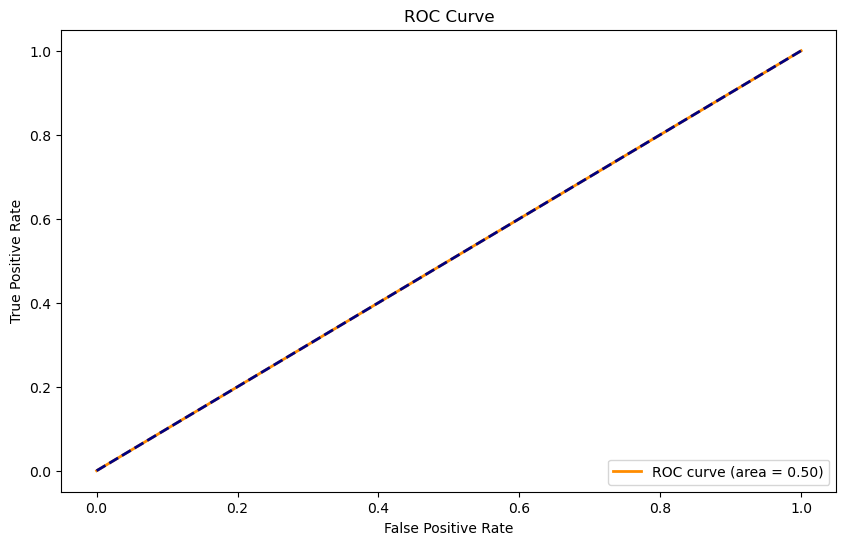

In [33]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('pep_roc.png')
plt.show()

financial eval

In [34]:
df = df.drop(index=0)
df = df.drop(['High', 'Low', 'Volume', 'Adj Close'], axis=1)
y_pred_binary = y_pred_binary.flatten()
df.loc[len(df) - len(y_pred_binary) + 1:len(df), 'y_test_pred_binary'] = y_pred_binary
new_df = df[['Date', 'Open', 'Close','y_test_pred_binary']].copy()
df = new_df.tail(len(y_pred_binary))
df = df.reset_index(drop=True)

In [35]:
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None) 

df['signal'] = ''


if df['y_test_pred_binary'].iloc[0] == 1:
    df.at[0, 'signal'] = 'buy'
elif df['y_test_pred_binary'].iloc[0] == 0:
    df.at[0, 'signal'] = 'sell'


for i in range(1, len(df)):
    if df['y_test_pred_binary'].iloc[i] != df['y_test_pred_binary'].iloc[i - 1]:
        if df['y_test_pred_binary'].iloc[i] == 1:
            df.at[i, 'signal'] = 'buy'
        elif df['y_test_pred_binary'].iloc[i] == 0:
            df.at[i, 'signal'] = 'sell'
    else:
        df.at[i, 'signal'] = ''


In [36]:
initial_capital = 10000
stock_quantity = 0
transaction_count = 0

remaining_money_list = []
new_stock_list = []

for index, row in df.iterrows():
    signal = row['signal']
    opening_price = row['Open']

    if signal == 'buy':
        stock_quantity = initial_capital // opening_price
        initial_capital -= stock_quantity * opening_price
        transaction_count += 1
    elif signal == 'sell' and stock_quantity > 0:
        initial_capital += stock_quantity * opening_price
        stock_quantity = 0
        transaction_count += 1

    remaining_money_list.append(initial_capital)
    new_stock_list.append(stock_quantity)

df['Remaining_Money'] = remaining_money_list
df['New_Stock'] = new_stock_list

print("Remaining Money")
remaining_money = df.loc[len(df) - 1, 'Remaining_Money']
print(remaining_money)
new_stock = df.loc[len(df) - 1, 'New_Stock']
print("New Stock")
print(new_stock)
final_close = df.loc[len(df) - 1, 'Close']
print("Final Close")
print(final_close)
final_capital = final_close*new_stock+remaining_money
print("Final Capital")
print(final_capital)

Remaining Money
60.93205261229923
New Stock
91.0
Final Close
109.3499984741211
Final Capital
10011.781913757319


In [37]:
first_opening = df.loc[0, 'Open']
initial_capital = 10000
stock_quantity = initial_capital // first_opening
initial_capital = initial_capital-stock_quantity*first_opening
initial_capital += stock_quantity * final_close
print("Final Close")
print(final_close)
print(f"Buy and Hold: Capital = {initial_capital}")

Final Close
109.3499984741211
Buy and Hold: Capital = 9528.460159301758


In [ ]:
import os
pid = os.getpid()
!kill -9 $pid